# Select best model

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from tempfile import mkdtemp
from shutil import rmtree
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier

## Load data

In [2]:
df = pd.read_csv("../raw_data/wra_CT_PM_conclusions.csv", index_col=0)

In [3]:
df['thera_count'] = df['Therapeutic area'].apply(lambda x: x.count(',') + 1)

In [4]:
df.conclusions.fillna("", inplace=True)

In [5]:
df.head()

,Medicine name,Therapeutic area,INN,Authorisation status,Orphan medicine,First published,n_trials,status_not_yet_recruiting,status_recruiting,status_enrolling_by_invitation,...,org_other_gov,phase_early_1,phase_not_applicable,phase_1,phase_2,phase_3,phase_4,pm_results,conclusions,thera_count
0,DuoTrav,"Open-Angle Glaucoma, Ocular Hypertension",travoprost / timolol,0,0,2018-02-15 01:00:00,54,0,2,0,...,2,0,2,1,2,17,30,44,Travoprost/timolol group resulted in an IOP r...,2
1,Palynziq,Phenylketonurias,pegvaliase,0,1,2019-05-29 13:43:00,12,0,2,0,...,0,0,0,1,4,3,0,11,A total of 34 guidance statements were includ...,1
2,Ifirmacombi,Hypertension,irbesartan / hydrochlorothiazide,0,0,2017-12-20 12:01:00,20,0,0,0,...,0,0,2,0,0,5,12,36,The prevalence of microalbuminuria and left v...,1
3,Topotecan Hospira,"Uterine Cervical Neoplasms, Small Cell Lung Ca...",topotecan,0,0,2018-04-13 20:29:00,111,3,8,0,...,4,1,0,34,65,21,0,523,We conducted laboratory studies which found s...,2
4,CoAprovel,Hypertension,irbesartan / hydrochlorothiazide,0,0,2017-08-22 00:09:00,20,0,0,0,...,0,0,2,0,0,5,12,36,The prevalence of microalbuminuria and left v...,1


## Models

### rfc

In [11]:
X = df[['org_industry',  'n_trials',  'phase_4',
             'org_other', 'status_completed', 'status_recruiting',
             'phase_3',  'pm_results', 'status_not_yet_recruiting',
             'phase_2', 'thera_count','conclusions']]

y = df['Authorisation status']


In [12]:
rfc = Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('vectorize',
                                                  TfidfVectorizer(max_df=0.9,
                                                                  max_features=15,
                                                                  min_df=0),
                                                  'conclusions'),
                                                 ('scale', RobustScaler(),
                                                  ['org_industry', 'n_trials',
                                                   'phase_4', 'org_other',
                                                   'status_completed',
                                                   'status_recruiting',
                                                   'phase_3', 'pm_results',
                                                   'status_not_yet_recruiting',
                                                   'phase_2',
                                                   'thera_count'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=2,
                                        random_state=0))])

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('vectorize',
                                                  TfidfVectorizer(max_df=0.9,
                                                                  max_features=15,
                                                                  min_df=0),
                                                  'conclusions'),
                                                 ('scale', RobustScaler(),
                                                  ['org_industry', 'n_trials',
                                                   'phase_4', 'org_other',
                                                   'status_completed',
                                                   'status_recruiting',
                                                   'phase_3', 'pm_results',
                                                   'status_not_yet_recruiting',
                                                   'phase_2',
           

## Evaluate

In [6]:
RANDOM_STATE = 30 # random integer from random.org

In [14]:
TEST_SIZE = 0.2

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [16]:
rfc.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('vectorize',
                                                  TfidfVectorizer(max_df=0.9,
                                                                  max_features=15,
                                                                  min_df=0),
                                                  'conclusions'),
                                                 ('scale', RobustScaler(),
                                                  ['org_industry', 'n_trials',
                                                   'phase_4', 'org_other',
                                                   'status_completed',
                                                   'status_recruiting',
                                                   'phase_3', 'pm_results',
                                                   'status_not_yet_recruiting',
                                                   'phase_2',
           

In [17]:
print(classification_report(y_test, rfc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.74      0.83       240
           1       0.27      0.70      0.39        33

    accuracy                           0.74       273
   macro avg       0.61      0.72      0.61       273
weighted avg       0.87      0.74      0.78       273



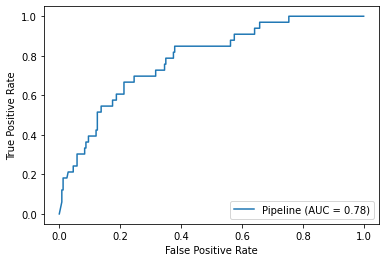

In [20]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(rfc, X_test, y_test)

In [22]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, rfc.predict(X_test))

0.7193181818181819

### Confidence interval functions

from https://github.com/mateuszbuda/ml-stat-util

In [ ]:
def score_ci(
    y_true,
    y_pred,
    score_fun,
    n_bootstraps=2000,
    confidence_level=0.95,
    seed=None,
    reject_one_class_samples=True,
):
    """
    Compute confidence interval for given score function based on labels and predictions using bootstrapping.
    :param y_true: 1D list or array of labels.
    :param y_pred: 1D list or array of predictions corresponding to elements in y_true.
    :param score_fun: Score function for which confidence interval is computed. (e.g. sklearn.metrics.accuracy_score)
    :param n_bootstraps: The number of bootstraps. (default: 2000)
    :param confidence_level: Confidence level for computing confidence interval. (default: 0.95)
    :param seed: Random seed for reproducibility. (default: None)
    :param reject_one_class_samples: Whether to reject bootstrapped samples with only one label. For scores like AUC we
    need at least one positive and one negative sample. (default: True)
    :return: Score evaluated on labels and predictions, lower confidence interval, upper confidence interval, array of
    bootstrapped scores.
    """

    assert len(y_true) == len(y_pred)

    score = score_fun(y_true, y_pred)
    _, ci_lower, ci_upper, scores = score_stat_ci(
        y_true=y_true,
        y_preds=y_pred,
        score_fun=score_fun,
        n_bootstraps=n_bootstraps,
        confidence_level=confidence_level,
        seed=seed,
        reject_one_class_samples=reject_one_class_samples,
    )

    return score, ci_lower, ci_upper, scores

def score_stat_ci(
    y_true,
    y_preds,
    score_fun,
    stat_fun=np.mean,
    n_bootstraps=2000,
    confidence_level=0.95,
    seed=None,
    reject_one_class_samples=True,
):
    """
    Compute confidence interval for given statistic of a score function based on labels and predictions using
    bootstrapping.
    :param y_true: 1D list or array of labels.
    :param y_preds: A list of lists or 2D array of predictions corresponding to elements in y_true.
    :param score_fun: Score function for which confidence interval is computed. (e.g. sklearn.metrics.accuracy_score)
    :param stat_fun: Statistic for which confidence interval is computed. (e.g. np.mean)
    :param n_bootstraps: The number of bootstraps. (default: 2000)
    :param confidence_level: Confidence level for computing confidence interval. (default: 0.95)
    :param seed: Random seed for reproducibility. (default: None)
    :param reject_one_class_samples: Whether to reject bootstrapped samples with only one label. For scores like AUC we
    need at least one positive and one negative sample. (default: True)
    :return: Mean score statistic evaluated on labels and predictions, lower confidence interval, upper confidence
    interval, array of bootstrapped scores.
    """

    y_true = np.array(y_true)
    y_preds = np.atleast_2d(y_preds)
    assert all(len(y_true) == len(y) for y in y_preds)

    np.random.seed(seed)
    scores = []
    for i in range(n_bootstraps):
        readers = np.random.randint(0, len(y_preds), len(y_preds))
        indices = np.random.randint(0, len(y_true), len(y_true))
        if reject_one_class_samples and len(np.unique(y_true[indices])) < 2:
            continue
        reader_scores = []
        for r in readers:
            reader_scores.append(score_fun(y_true[indices], y_preds[r][indices]))
        scores.append(stat_fun(reader_scores))

    mean_score = np.mean(scores)
    sorted_scores = np.array(sorted(scores))
    alpha = (1.0 - confidence_level) / 2.0
    ci_lower = sorted_scores[int(round(alpha * len(sorted_scores)))]
    ci_upper = sorted_scores[int(round((1.0 - alpha) * len(sorted_scores)))]
    return mean_score, ci_lower, ci_upper, scores